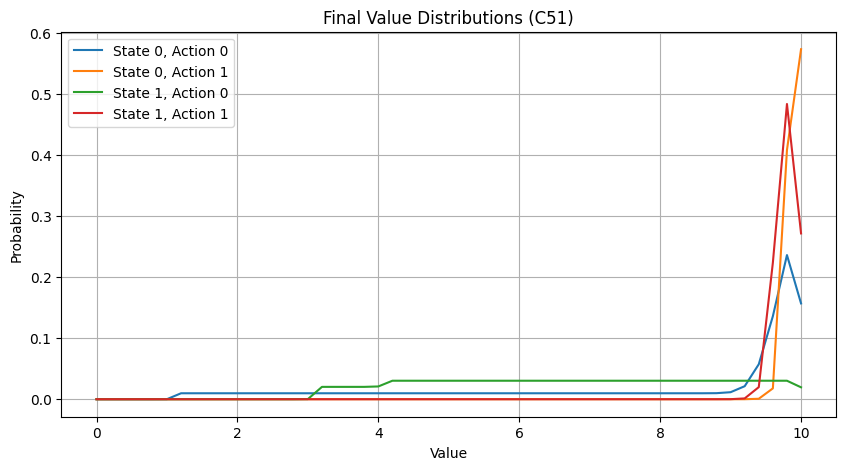

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Define MDP with 2 states and 2 actions
states = [0, 1]  # S1, S2
actions = [0, 1]  # A1, A2

# Transition matrix: P(s'|s, a)
# Each row represents (s, a) → [prob(s'=0), prob(s'=1)]
transitions = {
    (0, 0): [0.8, 0.2],  # S1, A1
    (0, 1): [0.3, 0.7],  # S1, A2
    (1, 0): [0.5, 0.5],  # S2, A1
    (1, 1): [0.9, 0.1],  # S2, A2
}

# Rewards
rewards = {
    (0, 0): 1,  # S1, A1
    (0, 1): 2,  # S1, A2
    (1, 0): 3,  # S2, A1
    (1, 1): 0,  # S2, A2
}

# Discount factor
gamma = 0.99

# Number of atoms in categorical distribution
num_atoms = 51
v_min, v_max = 0, 10  # Value distribution bounds
delta_z = (v_max - v_min) / (num_atoms - 1)  # Atom spacing
z_atoms = np.linspace(v_min, v_max, num_atoms)  # Support for categorical distribution

# Initialize distributions uniformly
distributions = {
    (0, 0): np.ones(num_atoms) / num_atoms,  # P(Z|s1, a1)
    (0, 1): np.ones(num_atoms) / num_atoms,  # P(Z|s1, a2)
    (1, 0): np.ones(num_atoms) / num_atoms,  # P(Z|s2, a1)
    (1, 1): np.ones(num_atoms) / num_atoms,  # P(Z|s2, a2)
}

# C51 Bellman update function
def update_distribution(state, action):
    next_state_probs = transitions[(state, action)]
    reward = rewards[(state, action)]

    new_dist = np.zeros(num_atoms)
    for next_state, prob in enumerate(next_state_probs):
        # Compute projected distribution
        v_proj = reward + gamma * z_atoms  # Apply Bellman equation
        v_proj = np.clip(v_proj, v_min, v_max)  # Clip within bounds

        # Compute probability mass transfer
        b = (v_proj - v_min) / delta_z
        l, u = np.floor(b).astype(int), np.ceil(b).astype(int)

        for i in range(num_atoms):
            l_i, u_i = l[i], u[i]
            weight_l = (u[i] - b[i]) * prob
            weight_u = (b[i] - l[i]) * prob

            if 0 <= l_i < num_atoms:
                new_dist[l_i] += weight_l * distributions[(next_state, action)][i]
            if 0 <= u_i < num_atoms:
                new_dist[u_i] += weight_u * distributions[(next_state, action)][i]

    new_dist_sum = new_dist.sum()
    if new_dist_sum > 0:
        return new_dist / new_dist_sum  # Normalize safely
    else:
        return np.ones(num_atoms) / num_atoms  # Avoid division by zero

num_iterations = 100
for _ in range(num_iterations):
    for s in states:
        for a in actions:
            distributions[(s, a)] = update_distribution(s, a)

plt.figure(figsize=(10, 5))
for (s, a), dist in distributions.items():
    plt.plot(z_atoms, dist, label=f"State {s}, Action {a}")

plt.xlabel("Value")
plt.ylabel("Probability")
plt.title("Final Value Distributions (C51)")
plt.legend()
plt.grid()
plt.show()
